In [ ]:
pip install hyperopt

In [37]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from xgboost import XGBRegressor

In [2]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


In [5]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [6]:
train_df.drop("Id", axis = 1, inplace = True)
numerical_fea = train_df.select_dtypes(include = ["float", "int"]).columns
types = train_df.dtypes
missing = round((train_df.isnull().sum() / train_df.shape[0]), 5) * 100
info = train_df.apply(lambda x: [round(x.min()), round(x.max()), round(x.min()), round(x.median())] if x.name in numerical_fea else None)
outliers = train_df.apply(lambda x: sum( (x < (x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) | \
                                          (x > (x.quantile(0.25) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) \
                                        if x.name in numerical_fea else ""))
explore = pd.DataFrame({"Types" : types, "Missing" :missing, "Info" : info, "Outliers" : outliers}).sort_values(by = ["Types", "Missing"])
explore.transpose()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MasVnrArea,GarageYrBlt,LotFrontage,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition,Electrical,MasVnrType,BsmtQual,BsmtCond,BsmtFinType1,BsmtExposure,BsmtFinType2,GarageType,GarageFinish,GarageQual,GarageCond,FireplaceQu,Fence,Alley,MiscFeature,PoolQC
Types,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
Missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.548,5.548,17.74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.068,0.548,2.534,2.534,2.534,2.603,2.603,5.548,5.548,5.548,5.548,47.26,80.753,93.767,96.301,99.521
Info,"[20, 190, 20, 50.0]","[1300, 215245, 1300, 9478.0]","[1, 10, 1, 6.0]","[1, 9, 1, 5.0]","[1872, 2010, 1872, 1973.0]","[1950, 2010, 1950, 1994.0]","[0, 5644, 0, 384.0]","[0, 1474, 0, 0.0]","[0, 2336, 0, 478.0]","[0, 6110, 0, 992.0]","[334, 4692, 334, 1087.0]","[0, 2065, 0, 0.0]","[0, 572, 0, 0.0]","[334, 5642, 334, 1464.0]","[0, 3, 0, 0.0]","[0, 2, 0, 0.0]","[0, 3, 0, 2.0]","[0, 2, 0, 0.0]","[0, 8, 0, 3.0]","[0, 3, 0, 1.0]","[2, 14, 2, 6.0]","[0, 3, 0, 1.0]","[0, 4, 0, 2.0]","[0, 1418, 0, 480.0]","[0, 857, 0, 0.0]","[0, 547, 0, 25.0]","[0, 552, 0, 0.0]","[0, 508, 0, 0.0]","[0, 480, 0, 0.0]","[0, 738, 0, 0.0]","[0, 15500, 0, 0.0]","[1, 12, 1, 6.0]","[2006, 2010, 2006, 2008.0]","[34900, 755000, 34900, 163000.0]","[0, 1600, 0, 0.0]","[1900, 2010, 1900, 1980.0]","[21, 313, 21, 69.0]",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Outliers,190,194,63,330,7,0,146,167,183,219,173,95,26,168,16,82,33,12,248,68,152,120,186,185,156,227,208,24,116,7,52,227,0,203,235,0,200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
print(train_df.Utilities.value_counts())
print(test_df.Utilities.value_counts())

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
AllPub    1457
Name: Utilities, dtype: int64


In [8]:
#train_df.drop(["Utilities"], axis = 1, inplace = True)
#test_df.drop(["Utilities"], axis = 1, inplace = True)


In [9]:
train_df.drop(["Utilities", "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis = 1, inplace = True)
test_df.drop(["Utilities", "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis = 1, inplace = True)

numerical_fea = train_df.select_dtypes(include = ["float", "int"]).columns

In [10]:
for col in (#'Alley',
            'MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2',#'FireplaceQu',
            'GarageType','GarageFinish','GarageQual','GarageCond',
           #'PoolQC','Fence','MiscFeature'
            ):
    train_df[col]=train_df[col].fillna('None')
    test_df[col]=test_df[col].fillna('None')

In [11]:
for col in ('Electrical','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    train_df[col]=train_df[col].fillna(train_df[col].mode()[0])
    test_df[col]=test_df[col].fillna(train_df[col].mode()[0])

In [12]:
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
            'GarageYrBlt','GarageCars','GarageArea'):
    train_df[col]=train_df[col].fillna(0)
    test_df[col]=test_df[col].fillna(0)

In [13]:
train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))
test_df["LotFrontage"] = test_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))
test_df['MSZoning'] = test_df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [14]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


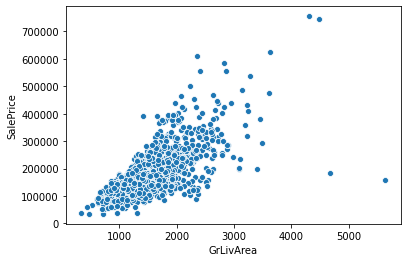

In [15]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data= train_df)

In [16]:
train_df = train_df[train_df["GrLivArea"] < 4000]

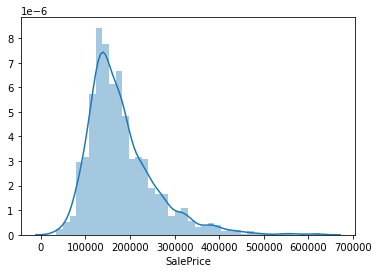

In [17]:
sns.distplot(train_df['SalePrice'])

In [18]:
train_df.SalePrice = np.log(train_df.SalePrice)

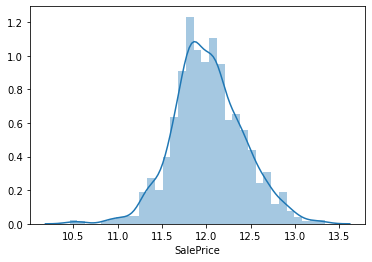

In [19]:
sns.distplot(train_df['SalePrice'])

In [20]:
train_df['TotalPorchArea'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch']
test_df['TotalPorchArea'] = test_df['OpenPorchSF'] + test_df['EnclosedPorch'] + test_df['3SsnPorch'] + test_df['ScreenPorch']

In [21]:
train_df['TotalBath'] = train_df['BsmtFullBath'] + train_df['BsmtHalfBath'] + train_df['FullBath'] + train_df['HalfBath']
test_df['TotalBath'] = test_df['BsmtFullBath'] + test_df['BsmtHalfBath'] + test_df['FullBath'] + test_df['HalfBath']

In [22]:
train_df['haspool'] = train_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_df['haspool'] = test_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_df['hasgarage'] = train_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test_df['hasgarage'] = test_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_df['hasbsmt'] = train_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test_df['hasbsmt'] = test_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_df['hasfireplace'] = train_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
test_df['hasfireplace'] = test_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [23]:
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']

In [24]:
train_df["HouseAge"] = train_df["HouseAge"].apply(lambda x: x if x > 0 else 0)
test_df["HouseAge"] = test_df["HouseAge"].apply(lambda x: x if x > 0 else 0)

In [25]:


# turning some ordered categorical variables into ordered numerical
# maybe this information about order can help on performance
for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual",
            "GarageQual","GarageCond",#"FireplaceQu","PoolQC"
            ]:
    train_df[col]= train_df[col].map({"Ex": 5, "Gd": 4 , "TA": 3, "Fa":2, "Po":1, "None" : 0})
    test_df[col]= test_df[col].map({"Ex": 5, "Gd": 4 , "TA": 3, "Fa":2, "Po":1, "None" : 0})

In [26]:
train_df['MSSubClass'] = train_df['MSSubClass'].astype(str)
test_df['MSSubClass'] = test_df['MSSubClass'].astype(str)
train_df['YrSold'] = train_df['YrSold'].astype(str)
test_df['YrSold'] = test_df['YrSold'].astype(str)
train_df['MoSold'] = train_df['MoSold'].astype(str)
test_df['MoSold'] = test_df['MoSold'].astype(str)

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSSubClass      1456 non-null   object 
 1   MSZoning        1456 non-null   object 
 2   LotFrontage     1456 non-null   float64
 3   LotArea         1456 non-null   int64  
 4   Street          1456 non-null   object 
 5   LotShape        1456 non-null   object 
 6   LandContour     1456 non-null   object 
 7   LotConfig       1456 non-null   object 
 8   LandSlope       1456 non-null   object 
 9   Neighborhood    1456 non-null   object 
 10  Condition1      1456 non-null   object 
 11  Condition2      1456 non-null   object 
 12  BldgType        1456 non-null   object 
 13  HouseStyle      1456 non-null   object 
 14  OverallQual     1456 non-null   int64  
 15  OverallCond     1456 non-null   int64  
 16  YearBuilt       1456 non-null   int64  
 17  YearRemodAdd    1456 non-null   i

In [28]:
numerical_fea_n = train_df.select_dtypes(include = ["float", "int"]).columns
skewness = train_df[numerical_fea_n].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
train_df[skewed_features] = np.log1p(train_df[skewed_features])
test_df[skewed_features] = np.log1p(test_df[skewed_features])

In [29]:
df_train = pd.get_dummies(train_df)
df_test = pd.get_dummies(test_df)

In [30]:
train_col = list(df_train.columns)
test_col = list(df_test.columns)
dif_col = [x for x in train_col if x not in test_col]
print(dif_col)

['SalePrice', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW', 'Electrical_Mix']


In [31]:
dif_col.remove("SalePrice")
df_train.drop(dif_col, axis = 1, inplace = True)

In [32]:
xtrain = df_train.drop("SalePrice", axis = 1)
ytrain = df_train.SalePrice

In [33]:
scaler = StandardScaler()
numerical = numerical_fea_n.drop("SalePrice")
xtrain.loc[:, numerical] = scaler.fit_transform(xtrain.loc[:, numerical])
df_test.loc[:, numerical] = scaler.transform(df_test.loc[:, numerical])



In [34]:
space = {'n_estimators':hp.quniform('n_estimators', 1000, 4000, 100),
         'gamma':hp.uniform('gamma', 0.01, 0.05),
         'learning_rate':hp.uniform('learning_rate', 0.00001, 0.025),
         'max_depth':hp.quniform('max_depth', 3,7,1),
         'subsample':hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.98),
         'colsample_bylevel':hp.uniform('colsample_bylevel', 0.60, 0.98),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'gamma': params['gamma'],
             'learning_rate': params['learning_rate'],
             'max_depth': int(params['max_depth']),
             'subsample': params['subsample'],
             'colsample_bytree': params['colsample_bytree'],
             'colsample_bylevel': params['colsample_bylevel'],
             'reg_lambda': params['reg_lambda']}
    
    xb_a= XGBRegressor(**params)
    score = cross_val_score(xb_a, xtrain, ytrain, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return -score

In [35]:
best = fmin(fn= objective, space= space, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████| 20/20 [25:29<00:00, 76.47s/it, best loss: 0.01338406748441941]


In [36]:
print(best)

{'colsample_bylevel': 0.6971640307744038, 'colsample_bytree': 0.6222251306452113, 'gamma': 0.045557016198868025, 'learning_rate': 0.012334455088591312, 'max_depth': 4.0, 'n_estimators': 2100.0, 'reg_lambda': 2.1713829044702413, 'subsample': 0.8459257473555255}


In [59]:
xb_b =XGBRegressor(random_state=0,
                   n_estimators=int(best['n_estimators']), 
                   colsample_bytree= best['colsample_bytree'],
                   gamma= best['gamma'],
                   learning_rate= best['learning_rate'],
                   max_depth= int(best['max_depth']),
                   subsample= best['subsample'],
                   colsample_bylevel= best['colsample_bylevel'],
                   reg_lambda= best['reg_lambda']
                       )

xb_b.fit(xtrain, ytrain)


[21:48:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6971640307744038, colsample_bynode=1,
             colsample_bytree=0.6222251306452113, gamma=0.045557016198868025,
             importance_type='gain', learning_rate=0.012334455088591312,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=2100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=2.1713829044702413,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8459257473555255, verbosity=1)

In [ ]:
importance = dict(zip(list(xb_b.feature_importances_), list(X_train.columns)))
for i, j in importance.items():
    if i < 0.0005:
        print(i,j)

0.0 SaleCondition_AdjLand
0.0004718957 PoolArea
0.0003806345 Neighborhood_NoRidge
0.00042345774 HouseStyle_2.5Unf


In [52]:
space_lasso = {"alpha" : hp.uniform("alpha", 0.0001, 0.1), "max_iter" : hp.uniform("max_iter", 100, 7000)}
def objective(params):
    lasso_model = Lasso(alpha = (params["alpha"]), max_iter = int(params["max_iter"]), random_state = 1)
    score = cross_val_score(lasso_model, xtrain, ytrain, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return -score

In [53]:
best_lasso = fmin(fn= objective, space= space_lasso, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████| 20/20 [00:01<00:00, 11.20it/s, best loss: 0.013065116905813379]


In [54]:
print(best_lasso)

{'alpha': 0.0014435601458621015, 'max_iter': 5829.753184230284}


In [55]:
lasso_m = Lasso(alpha = best_lasso["alpha"], max_iter = int(best_lasso["max_iter"]), random_state = 1)
lasso_m.fit(xtrain,ytrain)

Lasso(alpha=0.0014435601458621015, copy_X=True, fit_intercept=True,
      max_iter=5829, normalize=False, positive=False, precompute=False,
      random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

In [56]:
test = df_test.drop(["Id", "MSSubClass_150"], axis = 1)

In [60]:
preds = xb_b.predict(test)

In [61]:
f_preds = np.exp(preds)

In [62]:
preds_l = lasso_m.predict(test)
f_preds_l = np.exp(preds_l)

In [69]:
final = f_preds * 0.5 + f_preds_l * 0.5

In [70]:
output = pd.DataFrame({"Id" : df_test.Id, "SalePrice" : final})
output.to_csv("submission.csv", index = False)